In [16]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set(font_scale=2)

# What is the effect of infecting a small number of people during the early phase of an epidemic?


If, during the early phase of an epidemic, a few extra people become infected, this will have a few effects:
 - those people will be sick
 - those people will go on to cause additional infections
 - those people and their secondary contacts will not be infected later on, and will not at this point go on to cause additional infections
 
Infecting extra people early on will cause more infections overall as they have a larger pool of susceptible people to pass it on to.

It is not obvious what it will do to hospital stress. I expect that early infections will tend to "front load" the epidemic, but I'm not certain about this.

This simulation of a simple [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) asks how an epidemic differs if:
 1. The epidemic runs until there are $i_0$ infected people, $re_0$ recovered people and $s_0$ susceptible people
 2. We then consider two different scenarios:
     a. Nothing changes, the epidemic continues to run
     b. We add $\delta$ infected people and remove $\delta$ people from the susceptible pool, then the epidemic continues

We then compare these scenarios to see how they differ in terms of how many people are ultimately infected and how many people are infected over a country's hospital capacity (which we assume to be a constant fraction of the country's population)

What we find is that infecting $\delta$ people at any point while the number of infections is low compared to the total population has a very similar impact on the number of people infected total and on the stress the hospital system faces.

In [42]:
# Parameters

R0 = 3.5 # effective reproduction number
POP = 1e7 # total population of interest
gamma = 1 # what rate do infected people recover? gamma=1 essentially means that 1 'time unit' in the simulation is equal to 1 'infectious period'
RATES = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
REFFS = [1.5,2,3]

In [48]:
def geom(i,alpha):
    return i/(1-alpha) - i


def ds(s,i,pop=POP,r0=R0,gamma=gamma):
    return -s*i*r0*gamma/pop

def di(s,i,pop=POP,r0=R0,gamma=gamma):
    return -ds(s,i,pop,r0,gamma) - gamma*i


def simulate(tmax,i0,s0,pop=POP,r0=R0,gamma=gamma,step_size=1e-5):
    ins = [i0]
    ss = [s0]
    for t in range(int(tmax/step_size)):
        ins.append(ins[-1] + step_size*di(ss[-1],ins[-1],pop,r0,gamma))
        ss.append(ss[-1] + step_size*ds(ss[-1],ins[-2],pop,r0,gamma))
    return np.vstack([ins, ss])


def simulate_delta(delta,i0,pop=POP,r0=R0,thresh=2.5e-3,step_size=1e-5):
    re01 = geom(i0,1/r0)
    s1 = simulate(50,i0,pop-i0-re01,pop,r0,step_size=step_size)
    s2 = simulate(50,i0+delta,pop-i0-delta-re01,pop,r0,step_size=step_size)
    return s1, s2

def hospital_stress(s1,s2,thresh=2.5e-3,severe=1e-1,step_size=1e-5,pop=POP):
    inds1, inds2 = s1[0]*severe>=pop*thresh,s2[0]*severe>=pop*thresh
    
    return  (s2[0][inds2]-pop*thresh).sum()*step_size - (s1[0][inds1]-pop*thresh).sum()*step_size

def infections_delta(s1,s2):
    
    return  min(s1[1]) - min(s2[1])


def costs_of_infection(n=10,rates=RATES,reffs=REFFS):
    params = np.array([[a,b] for a in rates for b in reffs])
    data = {'Additional infections':[],'Hospital stress':[],'Prevalence' : params[:,0], 'Reff':params[:,1]}

    for rate, reff in zip(data['Prevalence'],data['Reff']):
        s1,s2 = simulate_delta(n,POP*rate,r0=reff)
        data['Hospital stress'].append(hospital_stress(s1,s2))
        data['Additional infections'].append(infections_delta(s1,s2))

    return pd.DataFrame(data)

In [67]:
data = costs_of_infection(100)/100
data[['Prevalence','Reff']] *= 100
sns.set()

for 0.1 background rate, we're seeing the effect of people entering hospital when infections are already past stress threshold

Text(0.5, 0, 'Prevalence of virus when infection occurs')

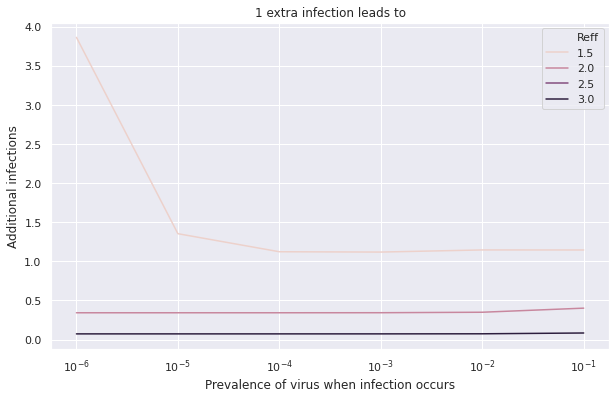

In [68]:
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=data,x='Prevalence',hue='Reff',y='Additional infections',ax=ax)
ax.set_xscale('log')
ax.set_title('1 extra infection leads to')
ax.set_xlabel('Prevalence of virus when infection occurs')

Text(0.5, 0, 'Prevalence of virus when infection occurs')

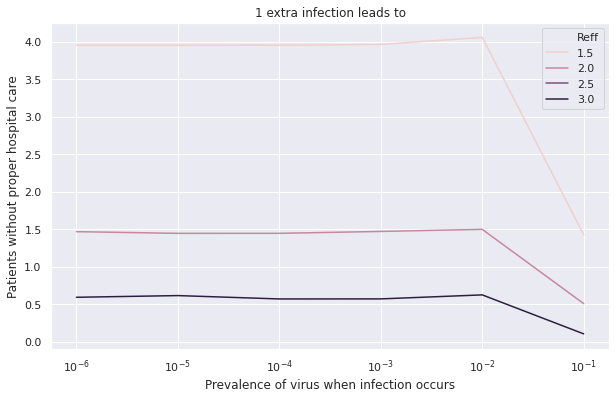

In [69]:
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=data,x='Prevalence',hue='Reff',y='Hospital stress',ax=ax)
ax.set_xscale('log')
ax.set_title('1 extra infection leads to')
ax.set_ylabel('Patients without proper hospital care')
ax.set_xlabel('Prevalence of virus when infection occurs')